In [61]:
# 5c22 Computational Method Assignment - Implementation of Bayesian Matting
# Author - Group : Yin Yang Artistic Chaos (Yuning, Abhishek, ChaiJie)

In [62]:
import numpy as np
from scipy.ndimage import gaussian_filter
import cv2
from numba import jit 
from PIL import Image 
import PIL 
import matplotlib.pyplot as plt

In [63]:
from orchard_bouman_clust import clustFunc

In [64]:
def matlab_style_gauss2d(shape=(3, 3), sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m, n = [(ss-1.)/2. for ss in shape]
    y, x = np.ogrid[-m:m+1, -n:n+1]
    h = np.exp(-(x*x + y*y)/(2.*sigma*sigma))
    h[h < np.finfo(h.dtype).eps*h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [65]:
@jit(nopython=True, cache=True)
def get_window(m, x, y, N):
    h, w, c = m.shape
    halfN = N//2
    r = np.zeros((N, N, c))
    xmin = max(0, x - halfN); xmax = min(w, x + (halfN+1))
    ymin = max(0, y - halfN); ymax = min(h, y + (halfN+1))
    pxmin = halfN - (x-xmin); pxmax = halfN + (xmax-x)
    pymin = halfN - (y-ymin); pymax = halfN + (ymax-y)

    r[pymin:pymax, pxmin:pxmax] = m[ymin:ymax, xmin:xmax]
    return r

In [66]:
@jit(nopython=True, cache=True)
def solve(mu_F, Sigma_F, mu_B, Sigma_B, C, sigma_C, alpha_init, maxIter, minLike):
    '''
    Solves for F,B and alpha that maximize the sum of log
    likelihoods at the given pixel C.
    input:
    mu_F - means of foreground clusters (for RGB, of size 3x#Fclusters)
    Sigma_F - covariances of foreground clusters (for RGB, of size
    3x3x#Fclusters)
    mu_B,Sigma_B - same for background clusters
    C - observed pixel
    alpha_init - initial value for alpha
    maxIter - maximal number of iterations
    minLike - minimal change in likelihood between consecutive iterations

    returns:
    F,B,alpha - estimate of foreground, background and alpha
    channel (for RGB, each of size 3x1)
    '''
    I = np.eye(3)
    FMax = np.zeros(3)
    BMax = np.zeros(3)
    alphaMax = 0
    maxlike = - np.inf
    invsgma2 = 1/sigma_C**2
    for i in range(mu_F.shape[0]):
        mu_Fi = mu_F[i]
        invSigma_Fi = np.linalg.inv(Sigma_F[i])
        for j in range(mu_B.shape[0]):
            mu_Bj = mu_B[j]
            invSigma_Bj = np.linalg.inv(Sigma_B[j])

            alpha = alpha_init
            myiter = 1
            lastLike = -1.7977e+308
            while True:
                # solve for F,B
                A11 = invSigma_Fi + I*alpha**2 * invsgma2
                A12 = I*alpha*(1-alpha) * invsgma2
                A22 = invSigma_Bj+I*(1-alpha)**2 * invsgma2
                A = np.vstack((np.hstack((A11, A12)), np.hstack((A12, A22))))
                b1 = invSigma_Fi @ mu_Fi + C*(alpha) * invsgma2
                b2 = invSigma_Bj @ mu_Bj + C*(1-alpha) * invsgma2
                b = np.atleast_2d(np.concatenate((b1, b2))).T

                X = np.linalg.solve(A, b)
                F = np.maximum(0, np.minimum(1, X[0:3]))
                B = np.maximum(0, np.minimum(1, X[3:6]))
                # solve for alpha

                alpha = np.maximum(0, np.minimum(1, ((np.atleast_2d(C).T-B).T @ (F-B))/np.sum((F-B)**2)))[0,0]
                # # calculate likelihood
                L_C = - np.sum((np.atleast_2d(C).T -alpha*F-(1-alpha)*B)**2) * invsgma2
                L_F = (- ((F- np.atleast_2d(mu_Fi).T).T @ invSigma_Fi @ (F-np.atleast_2d(mu_Fi).T))/2)[0,0]
                L_B = (- ((B- np.atleast_2d(mu_Bj).T).T @ invSigma_Bj @ (B-np.atleast_2d(mu_Bj).T))/2)[0,0]
                like = (L_C + L_F + L_B)
                #like = 0

                if like > maxlike:
                    alphaMax = alpha
                    maxLike = like
                    FMax = F.ravel()
                    BMax = B.ravel()

                if myiter >= maxIter or abs(like-lastLike) <= minLike:
                    break

                lastLike = like
                myiter += 1
    return FMax, BMax, alphaMax

In [67]:
def bayesian_matte(img, trimap, sigma=8, N=125, minN=10, N_max = 175):
    '''
    '''
    # Step 1 :- Taking the input image converting it into double and initializing alpha with image sizes
    im = img/255 
    h, w, c = im.shape 
    alpha = np.zeros((h, w))

    # Step 2 :- creates seperate logical matrix of foreground, backgound and unknown region
    fg_reg = trimap == 255
    bg_reg = trimap == 0
    unkmask = True ^ np.logical_or(fg_reg, bg_reg)

    # Step 3 :- Creating three channels for foreground and Background matrix 
    foreground = im*np.repeat(fg_reg[:, :, np.newaxis], 3, axis=2)
    background = im*np.repeat(bg_reg[:, :, np.newaxis], 3, axis=2)

    #Step 4 :- Creating only FG areas = 1 & unknown region = NaN in trimap, and creating new matrix for Foreground, Backgorund and Alpha for seperate computations 
    alpha[fg_reg] = 1
    F = np.zeros(im.shape)
    B = np.zeros(im.shape)
    Al_pha = np.zeros(trimap.shape)
    alpha[unkmask] = np.nan
    
    #step 5 : - Creating a sum of all the unknown pixels
    Unknown_sum = np.sum(unkmask)
    unkreg = unkmask
    
    # While Loop parameters and window counters
    n = 1
    m_i = 0
    max_li = 10
    kernel = np.ones((3, 3))

    while n < Unknown_sum:
        unkreg = cv2.erode(unkreg.astype(np.uint8), kernel, iterations=1)
        unkpixels = np.logical_and(np.logical_not(unkreg), unkmask)

        gaussian_weights = matlab_style_gauss2d((N, N), sigma)
        gaussian_weights = gaussian_weights/np.max(gaussian_weights)

        Y, X = np.nonzero(unkpixels)
        max_rep = 0
        for i in range(Y.shape[0]):
            if n % 100 == 0:
                print(n, Unknown_sum)
            y, x = Y[i], X[i]
            p = im[y, x]
            # Try cluster Fg, Bg in p's known neighborhood

            # take surrounding alpha values
            a = get_window(alpha[:, :, np.newaxis], x, y, N)[:, :, 0]

            # Take surrounding foreground pixels
            f_pixels = get_window(foreground, x, y, N)
            f_weights = (a**2 * gaussian_weights).ravel()

            f_pixels = np.reshape(f_pixels, (N*N, 3))
            posInds = np.nan_to_num(f_weights) > 0
            f_pixels = f_pixels[posInds, :]
            f_weights = f_weights[posInds]

            # Take surrounding foreground pixels
            b_pixels = get_window(background, x, y, N)
            b_weights = ((1-a)**2 * gaussian_weights).ravel()

            b_pixels = np.reshape(b_pixels, (N*N, 3))
            posInds = np.nan_to_num(b_weights) > 0
            b_pixels = b_pixels[posInds, :]
            b_weights = b_weights[posInds]

             # if not enough data, return to it later...
            if len(f_weights) < minN or len(b_weights) < minN:
                max_rep = max_rep + 1; 
            # Step 5.7.3.5* If whole iteration in the for loop runs without getting enough background or foreground values for some time, 
            # means the loop has become infinite as no more suitable window to calculate F,B and alpha, hence condition to break the loop and display the result accordingly.
                if (max_rep == len(Y)):
                    m_i = m_i + 1
                    if (m_i == max_li):
                        m_i = 0
                        N = N + 10
                        if (N == N_max):
                            n = Unknown_sum
                continue
            # Partition foreground and background pixels to clusters (in a weighted manner)
            mu_f, sigma_f = clustFunc(f_pixels, f_weights)
            mu_b, sigma_b = clustFunc(b_pixels, b_weights)

            alpha_init = np.nanmean(a.ravel())
            # Solve for F,B for all cluster pairs
            f, b, alphaT = solve(mu_f, sigma_f, mu_b, sigma_b, p, 0.01, alpha_init, 50, 1e-6)
            foreground[y, x] = f.ravel()
            background[y, x] = b.ravel()
            alpha[y, x] = alphaT
            unkmask[y, x] = 0
            n += 1

    return alpha

In [68]:
def main():
    #Step - Reading the input image, trimap and GT - alpha matte of that image.
    img = cv2.imread("C:/Users/aduttagu/Desktop/Bayesian-Matting-Implementation/input_training_lowres/GT01.png")[:, :, :3]
    trimap = cv2.imread("C:/Users/aduttagu/Desktop/Bayesian-Matting-Implementation/trimap_training_lowres/Trimap1/GT01.png")
    GT = cv2.imread("C:/Users/aduttagu/Desktop/Bayesian-Matting-Implementation/gt_training_lowres/GT01.png")
    trimap = trimap[:, :, 0]
    GT = GT[:, :, 0]

    #Step - Displaying the Alpha Matte and Ground Truth after calculating ALpha, Refer Function above for details
    alpha = bayesian_matte(img, trimap)

    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(alpha, cmap='gray')
    axes[0].set_title('Alpha Matte')
    axes[1].imshow(GT, cmap='gray')
    axes[1].set_title('Ground Truth')
    plt.show()

100 38573
200 38573
300 38573
400 38573
500 38573
600 38573
700 38573
800 38573
900 38573
1000 38573
1100 38573
1200 38573
1300 38573
1400 38573
1500 38573
1600 38573
1700 38573
1800 38573
1900 38573
2000 38573
2100 38573
2200 38573
2300 38573
2400 38573
2500 38573
2600 38573
2700 38573
2800 38573
2900 38573
3000 38573
3100 38573
3200 38573
3300 38573
3400 38573
3500 38573
3600 38573
3700 38573
3800 38573
3900 38573
4000 38573
4100 38573
4200 38573
4300 38573
4400 38573
4500 38573
4600 38573
4700 38573
4800 38573
4900 38573
5000 38573
5100 38573
5200 38573
5300 38573
5400 38573
5500 38573
5600 38573
5700 38573
5800 38573
5900 38573
6000 38573
6100 38573
6200 38573
6300 38573
6400 38573
6500 38573
6600 38573
6700 38573
6800 38573
6900 38573
7000 38573
7100 38573
7200 38573
7300 38573
7400 38573
7500 38573
7600 38573
7700 38573
7800 38573
7900 38573
8000 38573
8100 38573
8200 38573
8300 38573
8400 38573
8500 38573
8600 38573
8700 38573
8800 38573
8900 38573
9000 38573
9100 38573
9200 385

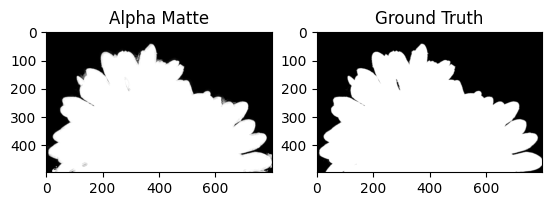

In [69]:
if __name__ == '__main__':
    import matplotlib.pyplot as plt
    import cv2
    main()

